In [ ]:
from io import open
import unicodedata
import string
import re
import random

import torch
from torchtext import data
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import string
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from __future__ import unicode_literals, print_function, division
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Importing IMDB Dataset

##Q 1.1) A Build a Markov (n-gram) language model
We have a markov language model with trigram. We have used Torch test to retrieve the IMDB dataset and custom function is used to generate trigrams which is passed as the preprocessing argument in the data.field function and transforms each review into trigrams. Also, freqs function is used to get the count of each trigram. Data is further manipulated to calculate probabilties and predictions are made my smapling these probabilities

In [ ]:
#Generate trigrams by passing in the data
def generate_trigrams(x):
    res = []
    n_grams = list(zip(*[x[i:] for i in range(3)]))
    for n_gram in n_grams:
        res.append(' '.join(n_gram))
    return res

In [ ]:
#Importing and preprocessing the data to convert into trigrams.
SEED = 12345
from torchtext import datasets
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
#importing imdb daaset
TEXT = data.Field(tokenize='spacy',preprocessing=generate_trigrams)
LABEL = data.LabelField(dtype=torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT,LABEL)
print(vars(train_data.examples[0]))
train_data, valid_data = train_data.split(random_state=random.seed(SEED),split_ratio=0.9)
TEXT.build_vocab(train_data)
dictionary = dict(TEXT.vocab.freqs)

aclImdb_v1.tar.gz:   0%|          | 295k/84.1M [00:00<00:32, 2.57MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 51.5MB/s]


{'text': ['I have the', 'have the entire', 'the entire Weissmuller', 'entire Weissmuller Tarzan', 'Weissmuller Tarzan series', 'Tarzan series on', 'series on DVD', 'on DVD (', 'DVD ( fully', '( fully restored', 'fully restored editions', 'restored editions )', 'editions ) &', ') & I', '& I never', 'I never tire', 'never tire of', 'tire of watching', 'of watching them', 'watching them .', 'them . My', '. My personal', 'My personal favorite', 'personal favorite is', 'favorite is "', 'is " Tarzan', '" Tarzan and', 'Tarzan and His', 'and His Mate', 'His Mate "', 'Mate " ,', '" , due', ', due entirely', 'due entirely (', 'entirely ( well', '( well almost', 'well almost entirely', 'almost entirely )', 'entirely ) to', ') to Maureen', "to Maureen O'Sullivan", "Maureen O'Sullivan 's", "O'Sullivan 's costume", "'s costume and", 'costume and the', 'and the occasional', 'the occasional flashes', 'occasional flashes of', 'flashes of her', 'of her genital', 'her genital area', 'genital area beneath

In [ ]:
#Output of a dictionary of which shows the count of each trigram.
dictionary

{'Now I recently': 1,
 'I recently had': 4,
 'recently had the': 4,
 'had the viewing': 1,
 'the viewing pleasure': 2,
 'viewing pleasure to': 2,
 'pleasure to watch': 27,
 'to watch the': 189,
 'watch the hilarious': 1,
 'the hilarious comedy': 1,
 'hilarious comedy Bachelor': 1,
 'comedy Bachelor Party': 1,
 'Bachelor Party ,': 2,
 'Party , one': 1,
 ', one of': 391,
 'one of my': 451,
 'of my new': 5,
 'my new favorite': 2,
 'new favorite comedies': 1,
 'favorite comedies ,': 1,
 'comedies , laughed': 1,
 ', laughed until': 1,
 'laughed until it': 1,
 'until it just': 1,
 'it just hurt': 1,
 'just hurt type': 1,
 'hurt type of': 1,
 'type of movies': 17,
 'of movies .': 36,
 'movies . So': 12,
 '. So I': 136,
 'So I naturally': 1,
 'I naturally wanted': 1,
 'naturally wanted to': 1,
 'wanted to see': 163,
 'to see the': 506,
 'see the sequel': 5,
 'the sequel ,': 19,
 'sequel , hoping': 1,
 ', hoping it': 8,
 'hoping it would': 21,
 'it would have': 253,
 'would have the': 15,
 'hav

In [ ]:
#Creating a dataframe of bigram and trigram where last word from trigram is 'target' for the bigram model. 'Cnt' represent count of trigrams
markov = pd.DataFrame.from_dict(dictionary,orient="index")
markov = markov.reset_index()
markov.columns = ['trigrams','cnt']
markov['bigram'] =markov.trigrams.apply(lambda x: " ".join(x.split(' ')[:2]))
markov['target'] =markov.trigrams.apply(lambda x: x.split(' ')[2])
markov


,trigrams,cnt,bigram,target
0,Movies have put,1,Movies have,put
1,have put me,2,have put,me
2,put me to,17,put me,to
3,me to sleep,15,me to,sleep
4,to sleep before,2,to sleep,before
...,...,...,...,...
3536997,have produced yet,1,have produced,yet
3536998,produced yet another,1,produced yet,another
3536999,yet another snickering,1,yet another,snickering
3537000,another snickering embarassment,1,another snickering,embarassment


In [ ]:
#Count of each bigram
inp_cnt = pd.DataFrame(markov.groupby("bigram",as_index=False)["cnt"].sum())
inp_cnt

,bigram,cnt
0,A Turkish,1
1,"\t """,2
2,\t Alex,1
3,\t Also,1
4,\t As,3
...,...,...
1325621,… although,1
1325622,… but,3
1325623,₤100 per,1
1325624,"₤250,000 in",1


## Q.1 1) B Change the output appropriately in ‘Simple Sentiment Analysis.ipynb’ to build an LSTM based language model. Plot the training performance as a function of epochs/iterations.

In [ ]:
SEED=1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['The', 'year', '2005', 'saw', 'no', 'fewer', 'than', '3', 'filmed', 'productions', 'of', 'H.', 'G.', 'Wells', "'", 'great', 'novel', ',', '"', 'War', 'of', 'the', 'Worlds', '"', '.', 'This', 'is', 'perhaps', 'the', 'least', 'well', '-', 'known', 'and', 'very', 'probably', 'the', 'best', 'of', 'them', '.', 'No', 'other', 'version', 'of', 'WotW', 'has', 'ever', 'attempted', 'not', 'only', 'to', 'present', 'the', 'story', 'very', 'much', 'as', 'Wells', 'wrote', 'it', ',', 'but', 'also', 'to', 'create', 'the', 'atmosphere', 'of', 'the', 'time', 'in', 'which', 'it', 'was', 'supposed', 'to', 'take', 'place', ':', 'the', 'last', 'year', 'of', 'the', '19th', 'Century', ',', '1900', '\x85 ', 'using', 'Wells', "'", 'original', 'setting', ',', 'in', 'and', 'near', 'Woking', ',', 'England.<br', '/><br', '/>IMDb', 'seems', 'unfriendly', 'to', 'what', 'they', 'regard', 'as', '"', 'spoilers', '"', '.', 'That', 'might', 'apply', 'with', 'some', 'films', ',', 'where', 'the', 'ending', 'might'

In [ ]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [ ]:
#Taking the 10000 most commonly used words in reviews
MAX_VOCAB_SIZE = 10000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [ ]:

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 10002
Unique tokens in LABEL vocabulary: 2


In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 203067), (',', 192631), ('.', 166305), ('and', 109610), ('a', 109559), ('of', 100576), ('to', 94057), ('is', 76455), ('in', 61626), ('I', 54641), ('it', 53553), ('that', 49552), ('"', 43965), ("'s", 43155), ('this', 42189), ('-', 37006), ('/><br', 35833), ('was', 35360), ('as', 30417), ('with', 29930)]


In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f2447349ae8>, {'neg': 0, 'pos': 1})


In [ ]:
BATCH_SIZE = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

Defining LSTM model

In [ ]:

import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, (hidden,cell) = self.lstm(embedded)
        #output, hidden = self.lstm(embedded)
        #print(hidden.dtype)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))
        #return self.fc(output)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,367,049 trainable parameters


In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#Function for checking accuracy
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#Function for training the model on training data of 17500 reviews
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#Function for evaluating model on evaluation data of 7500 reviews
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 14

best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 13s
	Train Loss: 0.693 | Train Acc: 50.31%
	 Val. Loss: 0.694 |  Val. Acc: 48.71%
Epoch: 02 | Epoch Time: 1m 13s
	Train Loss: 0.693 | Train Acc: 50.08%
	 Val. Loss: 0.694 |  Val. Acc: 48.60%
Epoch: 03 | Epoch Time: 1m 13s
	Train Loss: 0.693 | Train Acc: 49.73%
	 Val. Loss: 0.694 |  Val. Acc: 48.24%
Epoch: 04 | Epoch Time: 1m 13s
	Train Loss: 0.693 | Train Acc: 50.19%
	 Val. Loss: 0.694 |  Val. Acc: 48.73%
Epoch: 05 | Epoch Time: 1m 13s
	Train Loss: 0.693 | Train Acc: 50.37%
	 Val. Loss: 0.694 |  Val. Acc: 49.20%
Epoch: 06 | Epoch Time: 1m 13s
	Train Loss: 0.693 | Train Acc: 50.30%
	 Val. Loss: 0.694 |  Val. Acc: 49.25%
Epoch: 07 | Epoch Time: 1m 13s
	Train Loss: 0.693 | Train Acc: 50.57%
	 Val. Loss: 0.694 |  Val. Acc: 49.01%
Epoch: 08 | Epoch Time: 1m 13s
	Train Loss: 0.693 | Train Acc: 50.47%
	 Val. Loss: 0.694 |  Val. Acc: 49.44%
Epoch: 09 | Epoch Time: 1m 13s
	Train Loss: 0.693 | Train Acc: 49.60%
	 Val. Loss: 0.694 |  Val. Acc: 49.19%
Epoch: 10 | Epoch T

Plotting the training and evaluation performance as a function
of epochs/iterations.

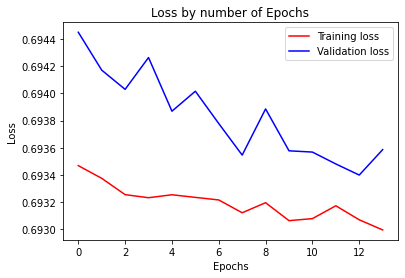

In [ ]:
plt.plot(train_losses,'r',label='Training loss')
plt.title("Training Performane by EPOCHS - 5000 words 80% training size")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss by number of Epochs') 
plt.plot(valid_losses,'b',label='Validation loss')
plt.legend(loc='upper right')
plt.show()

##Q 1.2) For each model, describe the key design choices made. Briefly mention how each choice influences training time and generative quality.

In [ ]:
Markov model we went with the trigrams and there was no difficulty in calculating the probabilities and prediction.
For LSTM there was an input layer followed by embedding then lstm layer. The input was the tokenized text and output also the tokenized text offsetted by 1 place. Ex) if input is [This,is,my,favorite,movie] then output is [is,my,favorite,movie,<

We took 25% training data with max 1000 words with batch size 10 to train our lstm model.
If we increased the number of words then the model couldn't be loaded into the gpu as there was insufficient memory
If we increased the training data to higher percentage say 50% or 80% then notebook got disconnected from the server randomly. This error didn't go when we tried to run the code as standalone .py file instead of a python notebook
When we reduced the batch size to 1 then model took longer time to train and when we increased it to 64 then there was memory error once again. We settled at Batch Size 10
Due to this limited training size and words the quality of sentence formed by predicition was affected considerably.The prediction didn't give out a coherent sentence as we would have liked.

**Markov Model**

We built Markov model with the trigrams. Initially, We have custom function is used to generate trigrams which is passed as the preprocessing argument in the data.field function and transforms each review into trigrams. Also, freqs function is used to get the count of each trigram and converted to a dictionary. Data is further manipulated to calculate probabilties and predictions are made my smapling these probabilities



**LSTM Model**

For LSTM model, there was an input layer followed by embedding then lstm layer and at the end output layer.

The key design choices made are for the following parameters:
1. Batch Size
Use of smaller batch size are shown to have faster convergence to good solution because smaller batch size allows the model to to “start learning before having to see all the data. If we increase the batch size to 100 we have memory issue and hence for above two reasons we took 10 to be the appropriate batch size.

2. Embedding Dimension
In case of word embedding the number of pairwise equidistant words of the corpus vocabulary gives a lower bound on the number of dimensions and going below this bound results in degradation of quality of learned word embeddings.
We have used word embedding of 100 Dimension as if we go lower value like 50 Dimension we would not be able to differentiate words whereas at higher dimension like 300 there will be even no relation between similar words like good and amazing making it reducing the accuracy on training data.

3. Vocabulary Size
The choice of vocabulary size is in line with the choice of embedding dimension. Plus, the higher number of word in the vocabulary allows the model to be trained better to with more words to give better performance for the model. Here we have chose the vocabulary size to be 10000. If we go beyond this number say 20000 then there was memory issue. Also training the modelk on lower vocabulary would train our model less accurately. So, we used vocabulary size of 10000.

4. Epoch
We used 35% (17500 reviews) of our data as training data and 15% validation data. Remaining 50% is used as test data. 

We have used the Early Stopping approach to determine the number of epochs: divide data in three data sets, training, validation and evaluation. Train each network along a sufficient number of epochs to see the training Mean Squared Error to be stuck in a minimum. The network for the epoch with the minimum validation MSE and once the loss has reached the value after which it was not changing much is selected for the evaluation process. Here it is coming to be 14




##Q 1. 3) For each model, starting with the phrase ”My favorite movie ”, sample the next few words and create a 20 word generated review. Repeat this 5 times (you should ideally get different outputs each time) and report the outputs.

##Markov Model Text generation

In [ ]:

def generate_sentence(sentence,no_preds,prediction_length):
    prediction_length -= len(sentence.split(" ")) 
    for j in range(0,no_preds):
        pred_sentence = sentence
        bi = " ".join(pred_sentence.split(" ")[1:])
        for i in range(0,prediction_length):
            poss_pred = np.array(markov.target[markov.bigram==bi])
            scores = np.array(markov.cnt[markov.bigram==bi])
            length = inp_cnt.cnt[inp_cnt.bigram==bi]
            probs = scores/length.iloc[0]
            pred = random.choice(list(enumerate(probs)))[0]
            pred = poss_pred[pred]
            pred_sentence = pred_sentence + " " + pred
            bi = " ".join([bi.split(" ")[1],pred])
        print("Markov model Generation "+str(j+1)+": ",pred_sentence+"\n")
generate_sentence("my favorite movie",5,20)

Markov model Generation 1:  my favorite movie as there would ( rightfully ) be topless , but starts to seeing Michael Madsen ! (

Markov model Generation 2:  my favorite movie a rating less than 10 lines so , too ; people who ultimately married the three suspects

Markov model Generation 3:  my favorite movie ever probably , one being tested , I disliked her so succeed . Of coming out soon

Markov model Generation 4:  my favorite movie ) types of bad Sci - Fi entertainment , this not so much anger toward McCoy and

Markov model Generation 5:  my favorite movie ( sort of wimp who was hanged , good taste public they will leave Mathieu confused ,



##LSTM Model Text generation

In [ ]:
#LSTM Prediction
def predict_LTSM(model, next_words=17):
  #x =torch.tensor([[TEXT.vocab.stoi["my"]],[TEXT.vocab.stoi["favorite"]],[TEXT.vocab.stoi["movie"]]],device="cuda:0")
  text='my favorite movie'
  words = text.split(' ')
  #TEXT.vocab.stoi['movie']

  for i in range(0, next_words):
    x = torch.tensor([[TEXT.vocab.stoi[w] for w in words[i:]]],device="cuda:0")
    
    y_pred = model(x)#, (state_h, state_c))
    #print(y_pred[0][-1])
    last_word_logits = y_pred[0]#[-1]
    
    p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()#.detach().numpy()
  
    word_index = np.random.choice(len(last_word_logits), p=p)
    words.append(TEXT.vocab.itos[word_index])

  return " ".join(words)

for j in range(0,5):
  #print(predict_LTSM(model))
  print("Generated Review"+str(j+1)+": ",predict_LTSM(model)+"\n")

Generated Review 1:  my favorite movie rental on this consisted of 4 , " Deerhunter " parody " angle as an encryption -

Generated Review 2:  my favorite movie from about five times and most brilliant stroke . She glides rather than organic . For 1980

Generated Review 3:  my favorite movie almost 10 years back called DINNER RUSH is highly satisfactory , and obviously runs into Connie first

Generated Review 4:  my favorite movie of yours was a route and reach Dawson only to turn gradually into psychological uneasiness eventually blossoming

Generated Review 5:  my favorite movie he plays his same old rubbish time after 45 years , nor ordinary . < hr >



#Sequence to Sequence Model for Translation (40pt)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import numpy as np
import os

## Reading Sentence Translation Data

In [ ]:
data_file = "/content/drive/My Drive/lang/mar-eng/mar.txt"
#data_file = "/content/drive/My Drive/lang/spa-eng/spa.txt"
f = open(data_file, 'r')
data_lines = f.readlines()

In [ ]:
language_x,language_y = [],[]
for line in data_lines:
  sentence = line.split("\t")
  language_x.append(sentence[1].strip())
  language_y.append(sentence[0].strip())

In [ ]:
language_x[170],language_y[170]

('मी गरीब आहे.', "I'm poor.")

In [ ]:
len(language_x)

40188

## Tokenizing data

In [ ]:
tokenizer_X = Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer_X.word_index['<pad>'] = 0
tokenizer_X.index_word[0] = '<pad>'
tokenizer_X.fit_on_texts(language_x)
sequence_x = tokenizer_X.texts_to_sequences(language_x)

tokenizer_y = Tokenizer(oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer_y.word_index['<pad>'] = 0
tokenizer_y.index_word[0] = '<pad>'
tokenizer_y.fit_on_texts(language_y)
sequence_y = tokenizer_y.texts_to_sequences(language_y)

In [ ]:
sequence_x[170],sequence_y[170]

([3, 657, 2], [29, 598])

## Padding Data

In [ ]:
sequence_x_padded = pad_sequences(sequence_x, padding='post')
sequence_y_padded = pad_sequences(sequence_y, padding='post')

In [ ]:
sequence_x_padded[40000]

array([    8,  4119,    43,  5105,    91, 13517,    43,  4627,   264,
         934,    63,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [ ]:
sequence_y_padded[40000]

array([ 36,  53, 655, 499,  19,   8, 323,  81, 588,  40,   8, 334,  81,
       759,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Splitting into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( sequence_x_padded, sequence_y_padded, test_size=0.05, random_state=12)

In [ ]:
X_train

array([[   3, 1038,  145, ...,    0,    0,    0],
       [   6,  505,   37, ...,    0,    0,    0],
       [  59,  782, 1970, ...,    0,    0,    0],
       ...,
       [  40, 6279, 9100, ...,    0,    0,    0],
       [   9,   62,  184, ...,    0,    0,    0],
       [3862, 2932,    2, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y_train

array([[  2,  77,   6, ...,   0,   0,   0],
       [412,   2, 138, ...,   0,   0,   0],
       [112,  71,  41, ...,   0,   0,   0],
       ...,
       [ 14, 305,  43, ...,   0,   0,   0],
       [  4,  45,  56, ...,   0,   0,   0],
       [ 39,   7,   8, ...,   0,   0,   0]], dtype=int32)

In [ ]:
print(tokenizer_X.sequences_to_texts([X_train[0]])[0].replace("<unk>","").strip())
print(tokenizer_y.sequences_to_texts([y_train[0]])[0].replace("<unk>","").strip())

मी दुकानात गेलो
i went to the shop


## Creating LSTM model

In [ ]:
x_vocab_size = len(tokenizer_X.word_index) + 1
y_vocab_size = len(tokenizer_y.word_index) + 1
x_length = len(X_train[0])
y_length = len(y_train[0])

print("Vocab size of original language: ",x_vocab_size)
print("Vocab size of translated language: ",y_vocab_size)
print("Vector length of each sentence in original language: ",x_length)
print("Vector length of each sentence i translated language: ",y_length)

Vocab size of original language:  13786
Vocab size of translated language:  5857
Vector length of each sentence in original language:  35
Vector length of each sentence i translated language:  35


In [ ]:
model = Sequential()
model.add(Embedding(x_vocab_size, 100, input_length=x_length, mask_zero=True))
model.add(LSTM(100))
model.add(RepeatVector(y_length))
model.add(LSTM(100, return_sequences=True))
model.add(Dense(y_vocab_size, activation='softmax'))
rms = RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           1378600   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 35, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 35, 100)           80400     
_________________________________________________________________
dense (Dense)                (None, 35, 5857)          591557    
Total params: 2,130,957
Trainable params: 2,130,957
Non-trainable params: 0
_________________________________________________________________


## Fitting Model

In [ ]:
checkpoint_path = "/content/drive/My Drive/lang/Checkpt_spa/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
checkpoint_path = "/content/drive/My Drive/lang/Checkpt_spa/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_split=0.1,callbacks=[cp_callback])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 0.2770
Epoch 00001: saving model to /content/drive/My Drive/lang/Checkpt_spa/cp.ckpt
537/537 [==============================] - 21s 39ms/step - loss: 0.2770 - val_loss: 0.5669
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 0.2736
Epoch 00002: saving model to /content/drive/My Drive/lang/Checkpt_spa/cp.ckpt
537/537 [==============================] - 19s 36ms/step - loss: 0.2736 - val_loss: 0.5710
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 0.2703
Epoch 00003: saving model to /content/drive/My Drive/lang/Checkpt_spa/cp.ckpt
537/537 [==============================] - 20s 36ms/step - loss: 0.2703 - val_loss: 0.5666
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 0.2666
Epoch 00004: saving model to /content/drive/My Drive/lang/Checkpt_spa/cp.ckpt
537/537 [==============================] - 19s 36ms/step - loss: 0.2666 - val_loss: 0.5712
Epoch 5/50
537/5

## Validating Prediction

In [ ]:
X_test.shape

In [ ]:
y_pred_logits = model.predict(X_test[:200])

In [ ]:
y_pred=[]
for pred in y_pred_logits: 
  y_pred.append(np.argmax(pred,1))

In [ ]:
y_pred_text = tokenizer_y.sequences_to_texts(y_pred)
y_test_text = tokenizer_y.sequences_to_texts(y_test[:200])
X_test_text = tokenizer_X.sequences_to_texts(X_test[:200])

In [ ]:
y_pred_text[145]

'we made him made <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>'

In [ ]:
print("Original Sentence: ",X_test_text[145].replace("<unk>","").strip())
print("Predicted Sentence: ",y_pred_text[145].replace("<unk>","").strip())
print("Actual Sentence: ",y_test_text[145].replace("<unk>","").strip())

Original Sentence:  आम्ही त्यांना पळवून लावलं
Predicted Sentence:  we made him made
Actual Sentence:  we drove them out


# PART 2 (Embedding using GloVe)

In [ ]:
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split( sequence_y_padded, sequence_x_padded, test_size=0.05, random_state=12)
tokenizer_X_g = tokenizer_y
tokenizer_y_g = tokenizer_X

In [ ]:
x_vocab_size_g = len(tokenizer_X_g.word_index) + 1
y_vocab_size_g = len(tokenizer_y_g.word_index) + 1
x_length_g = len(X_train_g[0])
y_length_g = len(y_train_g[0])

print("Vocab size of original language: ",x_vocab_size_g)
print("Vocab size of translated language: ",y_vocab_size_g)
print("Vector length of each sentence in original language: ",x_length_g)
print("Vector length of each sentence i translated language: ",y_length_g)

Vocab size of original language:  5857
Vocab size of translated language:  13786
Vector length of each sentence in original language:  35
Vector length of each sentence i translated language:  35


In [ ]:
embeddings_index = {}
f = open(os.path.join('/content/drive/My Drive/glove.6B/', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
word_i= tokenizer_X_g.word_index

In [ ]:
embedding_matrix = np.zeros((len(word_i) + 1, 100))
for word, i in word_i.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Model with GloVe Embedding

In [ ]:
model_g = Sequential()
model_g.add(Embedding(len(word_i) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=x_length_g,
                            trainable=False))
model_g.add(LSTM(100))
model_g.add(RepeatVector(y_length_g))
model_g.add(LSTM(100, return_sequences=True))
model_g.add(Dense(y_vocab_size_g, activation='softmax'))
rms = RMSprop(lr=0.001)
model_g.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
model_g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 100)           585700    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 35, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 35, 100)           80400     
_________________________________________________________________
dense_1 (Dense)              (None, 35, 13786)         1392386   
Total params: 2,138,886
Trainable params: 1,553,186
Non-trainable params: 585,700
_________________________________________________________________


In [ ]:
checkpoint_path_g = "/content/drive/My Drive/lang/Checkpt_spa_g/cp.ckpt"
checkpoint_dir_g = os.path.dirname(checkpoint_path_g)

# Create a callback that saves the model's weights
cp_callback_g = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_g,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
checkpoint_path = "/content/drive/My Drive/lang/Checkpt_spa_g/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path_g)
latest = tf.train.latest_checkpoint(checkpoint_dir_g)
model_g.load_weights(latest)

In [ ]:
history_g = model_g.fit(X_train_g, y_train_g, batch_size=64, epochs=50, validation_split=0.1,callbacks=[cp_callback_g])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 1.2596
Epoch 00001: saving model to /content/drive/My Drive/lang/Checkpt_spa_g/cp.ckpt
537/537 [==============================] - 33s 61ms/step - loss: 1.2596 - val_loss: 0.9618
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 0.9481
Epoch 00002: saving model to /content/drive/My Drive/lang/Checkpt_spa_g/cp.ckpt
537/537 [==============================] - 32s 59ms/step - loss: 0.9481 - val_loss: 0.9302
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 0.9294
Epoch 00003: saving model to /content/drive/My Drive/lang/Checkpt_spa_g/cp.ckpt
537/537 [==============================] - 32s 59ms/step - loss: 0.9294 - val_loss: 0.9381
Epoch 4/50
536/537 [============================>.] - ETA: 0s - loss: 0.9159
Epoch 00004: saving model to /content/drive/My Drive/lang/Checkpt_spa_g/cp.ckpt
537/537 [==============================] - 32s 59ms/step - loss: 0.9159 - val_loss: 0.9120
Epoch 5/

## Model 2 prediciton (Eng -> Other lang)

In [ ]:
y_pred_logits_g = model_g.predict(X_test_g)

y_pred_g=[]
for pred_g in y_pred_logits_g: 
  y_pred_g.append(np.argmax(pred_g,1))

In [ ]:
y_pred_text_g = tokenizer_y_g.sequences_to_texts(y_pred_g)
y_test_text_g = tokenizer_y_g.sequences_to_texts(y_test_g)
X_test_text_g = tokenizer_X_g.sequences_to_texts(X_test_g)

In [ ]:
print("Original Sentence: ",X_test_text_g[256].replace("<unk>","").strip())
print("Predicted Sentence: ",y_pred_text_g[256].replace("<unk>","").strip())
print("Actual Sentence: ",y_test_text_g[256].replace("<unk>","").strip())

Original Sentence:  where's my mama
Predicted Sentence:  माझी माझी कुठे आहे
Actual Sentence:  माझी मम्मा कुठे आहे


## Part 3: Testing on 5 examples

In [ ]:
five_example_sentence= np.array([X_test_g[120],X_test_g[-2],X_test_g[256],X_test_g[123],X_test_g[456]])

In [ ]:
five_example_sentence.shape

(5, 35)

#### Prediction from Model 2 (Eng -> Chosen Lang)

In [ ]:
y_pred_logits_model2 = model_g.predict(five_example_sentence)

y_pred_model2 =[]
for pred_model2  in y_pred_logits_model2 : 
  y_pred_model2.append(np.argmax(pred_model2 ,1))

In [ ]:
y_pred_text_model2  = tokenizer_y_g.sequences_to_texts(y_pred_model2)
y_pred_text_model2_cleaned =[]
for predicted in y_pred_text_model2:
  y_pred_text_model2_cleaned.append(predicted.replace("<unk>","").strip())

In [ ]:
print(y_pred_text_model2_cleaned)

['टॉमला येऊ', 'मला माझी पुस्तक दे', 'माझी माझी कुठे आहे', 'टॉम काहीतरी होता होता', 'टॉम आणि मेरी दोघेही आहेत']


#### Prediction from Model 1 (Chosen Lang -> Eng)

In [ ]:
model1_test_data_5 = pad_sequences(tokenizer_X.texts_to_sequences(y_pred_text_model2_cleaned),maxlen=X_test.shape[1],padding='post')

In [ ]:
y_pred_logits_model1 = model.predict(np.array(model1_test_data_5))

y_pred_model1=[]
for pred_model1 in y_pred_logits_model1: 
  y_pred_model1.append(np.argmax(pred_model1,1))

In [ ]:
y_pred_text_model1 = tokenizer_y.sequences_to_texts(y_pred_model1)
y_pred_text_model1_cleaned =[]
for predicted_model1 in y_pred_text_model1:
  y_pred_text_model1_cleaned.append(predicted_model1.replace("<unk>","").strip())

#### FINAL RESULTS

In [ ]:
original_example_sentence = tokenizer_y.sequences_to_texts(five_example_sentence)
original_cleaned=[]
for original in original_example_sentence:
  original_cleaned.append(original.replace("<unk>","").strip())

In [ ]:
for i in range(len(five_example_sentence)):
  print("Original Sentence:\t\t",original_cleaned[i])
  print("Predicted Sentence By Model 2:\t",y_pred_text_model2_cleaned[i])
  print("Predicted Sentence By Model 1:\t",y_pred_text_model1_cleaned[i])

Original Sentence:		 let tom in
Predicted Sentence By Model 2:	 टॉमला येऊ
Predicted Sentence By Model 1:	 tom come come
Original Sentence:		 give me my bag
Predicted Sentence By Model 2:	 मला माझी पुस्तक दे
Predicted Sentence By Model 1:	 give me the book
Original Sentence:		 where's my mama
Predicted Sentence By Model 2:	 माझी माझी कुठे आहे
Predicted Sentence By Model 1:	 where's my tom
Original Sentence:		 tom was hiding something
Predicted Sentence By Model 2:	 टॉम काहीतरी होता होता
Predicted Sentence By Model 1:	 tom was something
Original Sentence:		 tom and mary both laughed
Predicted Sentence By Model 2:	 टॉम आणि मेरी दोघेही आहेत
Predicted Sentence By Model 1:	 tom and both both
